## EXAM PROJECT (virginia-rebecca group) ##

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [17]:
# Import modules

import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
from workerclass import WorkerClass
from problem2 import Problem2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We solve the worker's maximization problem analytically to verify that we obtain the expression for the optimal labor $L^{\star}(\tilde{w})$ using Sympy.

In [18]:
# Define parameters in sympy 

c = sm.symbols('C') 
g = sm.symbols('G')
alpha1 = sm.symbols('alpha')
l = sm.symbols('L')
ni1 = sm.symbols('v')
kappa1 = sm.symbols('k')
w1 = sm.symbols('w')
tau1 = sm.symbols('t')
w_tilde = sm.symbols('w_tilde')

# Define constraint
consumption_constraint = kappa1+(1-tau1)*w1*l

# Define objective function
objective = sm.ln((c**alpha1)*(g**(1-alpha1)))-ni1*((l**2)/2)

# Substitute constraint into objective function
objective1 = objective.subs(c,consumption_constraint)

# Calculate foc w.r.t. l 
foc = sm.diff(objective1,l)

# Substitute w_tilde for w 
foc1 = foc.subs(w1*(1-tau1),w_tilde)

# Solve for l and simplify solution
sol = sm.solve(sm.Eq(foc1,0), l)
sol[1] # take positive solution
sol1 = sm.simplify(sol[1])
print('The optimal labor supply is:')
sol1

The optimal labor supply is:


(-k*v + sqrt(v*(4*alpha*w_tilde**2 + k**2*v)))/(2*v*w_tilde)

The result, simplified for $\nu $, is exaclty $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

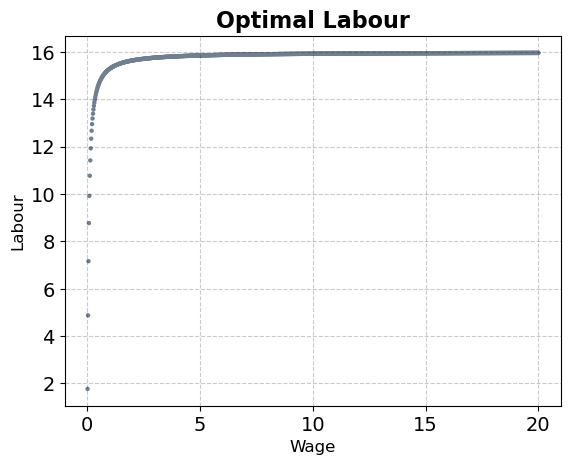

In [19]:
# Use WorkerClass 
model = WorkerClass()

# Define grid values for w 
w_vec = np.linspace(0.01,20,1000)

# Create vector for optimal labour 
l_func= np.empty(len(w_vec))

# Calculate optimal labour for each value of wage
for i,a in enumerate(w_vec):
    model.par.w = a
    l_func[i] = model.optimal_labor()

# Plot optimal labour as a function of wage
fig, ax = plt.subplots()
ax.scatter(w_vec, l_func, c='slategray', alpha=1, edgecolors='none', s=10)
ax.set_title('Optimal Labour', fontsize=16, fontweight='bold')
ax.set_xlabel('Wage', fontsize=12)
ax.set_ylabel('Labour', fontsize=12)
ax.grid(True, linestyle='--', alpha = 0.2)
plt.show()


The optimal labour increases with wage, but with smaller and smaller increments. This makes economic sense, since more wage leads to work more, but at high levels of wage the marginal benefit of working to obtain the wage to consume is lower. 


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


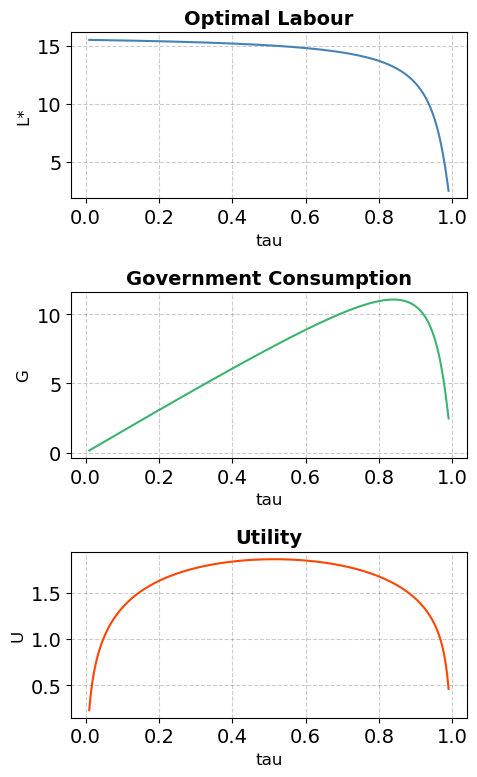

In [20]:
# Use WorkerClass
model2 = WorkerClass()

# Define grid values for tau 
t_grid = np.linspace(0.01,0.99,1000)

# Prepar vectors for looping
g_grid = np.empty(1000)
l_grid = np.empty(1000)
u_grid = np.empty(1000)

# Calculate optimal labour, government consumption and utility for each value of tau
for i,t in enumerate(t_grid):
    model2.par.tau = t
    l_grid[i] = model2.optimal_labor()
    g_grid[i] = model2.government()
    u_grid[i] = model2.utility()

# Plot 
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

# Plot 1 - Optimal labour
axs[0].plot(t_grid, l_grid, color='steelblue')
axs[0].set_xlabel('tau', fontsize=12)
axs[0].set_ylabel('L*', fontsize=12)
axs[0].set_title('Optimal Labour', fontsize=14, fontweight='bold')
axs[0].grid(True, linestyle='--', alpha=0.2)

# Plot 2 - Government consumption
axs[1].plot(t_grid, g_grid, color='mediumseagreen')
axs[1].set_xlabel('tau', fontsize=12)
axs[1].set_ylabel('G', fontsize=12)
axs[1].set_title('Government Consumption', fontsize=14, fontweight='bold')
axs[1].grid(True, linestyle='--', alpha=0.2)

# Plot 3 - Utility
axs[2].plot(t_grid, u_grid, color='orangered')
axs[2].set_xlabel('tau', fontsize=12)
axs[2].set_ylabel('U', fontsize=12)
axs[2].set_title('Utility', fontsize=14, fontweight='bold')
axs[2].grid(True, linestyle='--', alpha=0.2)

# Adjust spacing between subplots
fig.tight_layout()

plt.show()


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [21]:
# Use interpolation for tau and utility to obtain the utility function
interp_func = interpolate.RegularGridInterpolator([t_grid], u_grid,
                                                  bounds_error=False,
                                                  fill_value=None)

# Find tau that maximizes utility
max = optimize.minimize_scalar(lambda x: -interp_func([x]), bounds=(1e-8,1-1e-8), method='bounded')
tau_max = max.x
print('Socially optimal tax rate =', tau_max)


Socially optimal tax rate = [0.51422702]


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In the WorkerClass, we define a function that calculates the optimal labor for the worker's problem for a given value of G (optimal_lg, which is based on the generally formulated utility function calculated in utility2). Then the function "equation_to_solve" returns the equation $G -\tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ using the optimal_lg. In the code we find then the correct G searching for the G value that solves the equation (i.e. the root of the equation).

In [22]:
# Use WorkerClass with the first set of parameters
general_model = WorkerClass()

# Use tau found in question 4
general_model.par.tau = tau_max

# Find correct government consumption
res = optimize.root_scalar(general_model.equation_to_solve,bracket=[0.0001,30])
g_eq = res.root
print(f'With the first set of parameters, G = {g_eq:.2f}')

general_model2 = WorkerClass()
general_model2.par.tau = tau_max

# Set parameters to the second set of parameters and repeat procedure
general_model2.par.sigma = 1.5
general_model2.par.rho = 1.5
res2 = optimize.root_scalar(general_model2.equation_to_solve,bracket=[0.0001,30])
g_eq2 = res2.root
print(f'With the second set of parameters, G = {g_eq2:.2f}')


With the first set of parameters, G = 7.71
With the second set of parameters, G = 4.97


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

We loop through a grid of values for $\tau$ and apply the procedure of the previous question. Then we search the value of $\tau$ among the grid that maximizes utility. 

In [23]:
# Use WorkerClass with the first set of parameters

general_model6 = WorkerClass()

t_grid_6 = np.linspace(0.01,0.99,1000)
g6 = np.empty(1000)
l6 = np.empty(1000)
utility6 = np.empty(1000)

# Loop through a grid of values for tau and obtain correspondent G, L* and U
for i,t in enumerate(t_grid_6):
    general_model6.par.tau = t
    res6 = optimize.root_scalar(general_model6.equation_to_solve,bracket=[0.0001,30])
    g6[i] = res6.root
    l6[i] = general_model6.optimal_lg(g6[i])
    utility6[i] = general_model6.utility2(g6[i],l6[i])

# Use interpolation for tau and utility to obtain the utility function w.r.t tau
interp_func_6 = interpolate.RegularGridInterpolator([t_grid_6], utility6,
                                                  bounds_error=False,
                                                  fill_value=None)

# Find tau that maximizes utility
max_6 = optimize.minimize_scalar(lambda x: -interp_func_6([x]), bounds=(1e-8,1-1e-8), method='bounded')
tau_max_6 = max_6.x
print('Socially optimal tax rate with the first set of parameters =', tau_max_6)
   
# Apply the procedure for the second set of parameters 

general_model6bis = WorkerClass()
general_model6bis.par.sigma = 1.5
general_model6bis.par.rho = 1.5

t_grid_6bis = np.linspace(0.01,0.99,1000)
g6bis = np.empty(1000)
l6bis = np.empty(1000)
utility6bis = np.empty(1000)
for i,t in enumerate(t_grid_6bis):
    general_model6bis.par.tau = t
    res6bis = optimize.root_scalar(general_model6bis.equation_to_solve,bracket=[0.0001,30])
    g6bis[i] = res6bis.root
    l6bis[i] = general_model6bis.optimal_lg(g6bis[i])
    utility6bis[i] = general_model6bis.utility2(g6bis[i],l6bis[i])

interp_func_6bis = interpolate.RegularGridInterpolator([t_grid_6bis], utility6bis,
                                                  bounds_error=False,
                                                  fill_value=None)

# Find tau that maximizes utility
max_6bis = optimize.minimize_scalar(lambda x: -interp_func_6bis([x]), bounds=(1e-8,1-1e-8), method='bounded')
tau_max_6bis = max_6bis.x
print('Socially optimal tax rate with the second set of parameters =', tau_max_6bis)

Socially optimal tax rate with the first set of parameters = [0.51422376]
Socially optimal tax rate with the second set of parameters = [0.4622274]


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

To verify it numerically, we solve the profit maximization problem for $\ell_{t}$ (in the Problem2 class the function is optimal_labor2), then we calculate the expression for $\ell_{t}$ (in the Problem2 class the function is foc), given in the question with the parameters given and  we compare the two results. 

In [24]:
# Use Problem2 class
model3 = Problem2()

# Define vector k 
k_vec = [1.0, 2.0]

# Create vectors for optimal labour
l_vec_optimal = np.empty(len(k_vec))
foc_optimal = np.empty(len(k_vec))

# Loop through k_vec values
for i,k in enumerate(k_vec):
    model3.par.k = k 
    l_vec_optimal[i] = model3.optimal_labor2()
    foc_optimal[i]= model3.foc()
    print(f"Optimal l for kappa = {k_vec[i]:.1f}: {l_vec_optimal[i]:.2f}")
    print(f"Foc for kappa = {k_vec[i]:.1f}: {foc_optimal[i]:.2f}")

Optimal l for kappa = 1.0: 0.25
Foc for kappa = 1.0: 0.25
Optimal l for kappa = 2.0: 1.00
Foc for kappa = 2.0: 1.00


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

Firstly we set K-1 and the seed to replicate results. We loop through K-1, and for each k we drow a shock series distributed as a normal eith the parameters given. In Problem2 class we define a function (calc_k) that calculates the ex post value of the salon conditional on the shock series, which is explained in the class. Then we sum all the ex post values and we calculate the mean of them to obtain the ex ante value, H. 

In [25]:
# use Problem2 class
model4 = Problem2()

# Set K-1 and seed 
simulations = range(100)
np.random.seed(0)

# Create empty list for salon values
salon_values = []

# Loop through simulations
for k in simulations: 
    # Drow random shock series
    shock_series = np.random.normal(-0.5 * (model4.par.sigmae**2), model4.par.sigmae, model4.par.T)
    # Calculate salon value ex post
    salon_value = model4.calc_k(shock_series)
    # Append to list
    salon_values.append(salon_value)

# Calculate expected value
expected_value = np.mean(salon_values)
print(f'The expected value ex ante of the salon is {expected_value:.3f}')


The expected value ex ante of the salon is 26.658


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

We construct the function calc_k2 in the class with the new policy updated and repeat the procedure of Question 2. 

In [26]:
model5 = Problem2()
simulations = range(100)
np.random.seed(0)
salon_values = []

for k in simulations: 
    shock_series = np.random.normal(-0.5 * (model5.par.sigmae**2), model5.par.sigmae, model5.par.T)
    salon_value = model5.calc_k2(shock_series)
    salon_values.append(salon_value)


expected_value = np.mean(salon_values)

print(f'The expected value ex ante of the salon is {expected_value:.3f}')

The expected value ex ante of the salon is 27.351


Yes, it improves profitability (H is higher respect to the previous point). This is because it avoids to adjust the policy, and therefore pay the cost of it, when it is not so distant from the optimal one.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

We find the optimal delta maximizing H updating the parameter of delta in the function to calculate the ex post salone value (in the class now calc_k3), applying the loop through the simulations (with the function func_kk) and maximizing it with respect to delta (with the function optimal_delta). 

In [27]:
model6 = Problem2()
res6 = model6.optimal_delta()
print(f'The optimal Delta maximizing H is {res6:.3f}')

The optimal Delta maximizing H is 0.076


In [28]:
# Check value of H with optimal Delta 

model7 = Problem2()
model7.par.delta = res6

simulations = range(100)
np.random.seed(0)
salon_values = []
for k in simulations: 
    shock_series = np.random.normal(-0.5 * (model7.par.sigmae**2), model7.par.sigmae, model7.par.T)
    salon_value = model7.calc_k2(shock_series)
    salon_values.append(salon_value)
expected_value = np.mean(salon_values)
print(f'The expected value of the salon (H) is {expected_value:.3f}')

The expected value of the salon (H) is 27.408


The value ex ante of the salon is indeed higher with the optimal delta respect to the default delta 0.5. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



We calculate the profits with both the optimal policy and the previous policy. If the gain with the optimal policy is greater than the cost of changing policy (iota), we update the policy. The Problem2 class for it is calc_k4.

In [29]:
# Test our policy
model8 = Problem2()
simulations = range(100)
np.random.seed(0)
salon_values = []
for k in simulations: 
    shock_series = np.random.normal(-0.5 * (model8.par.sigmae**2), model8.par.sigmae, model8.par.T)
    salon_value = model8.calc_k4(shock_series)
    salon_values.append(salon_value)
expected_value = np.mean(salon_values)

print(f'The new expected value of the salon (H) is {expected_value:.3f}')

The new expected value of the salon (H) is 27.405


Our policy appears to be more profitable than the one in question 3 but not than the one in question 4.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [30]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [31]:
# Chosen settings
bounds = [-600, 600] # bounds for x1 ans x2
tau = 1e-8           # termination tolerance
K_warmup = 10        # number of warm-up iterations
K_max = 1000         # number of iterations
np.random.seed(1)

# Define function for global optimization
def refined_global_optimizer(bounds, tau, K_warmup, K_max):
    f_best = np.inf
    x_best = np.nan
    n_iterations = 0 

    for k in range(K_max):
        # drow x uniformily distributed
        x = np.random.uniform(bounds[0], bounds[1], size=2)
        
        if k >= K_warmup:
            # calculate chi
            chi = 0.5 * (2 / (1 + np.exp((k - K_warmup) / 100)))
            # calculate effective initial guess x_k0
            x_k0 = chi * x + (1 - chi) * x_best
        else:
            # during the warm-up period, use the original random initial guess
            x_k0 = x

        # run optimizer with x_k0 as initial guess
        result = optimize.minimize(griewank, x_k0, method='BFGS', tol=tau)
        
        x_kstar = result.x
    
        if k == 0 or result.fun < f_best: 
            x_best = result.x
            f_best = result.fun
        
        n_iterations += 1
        
        print(f'{k:4d}: x0 = ({x_k0[0]:7.2f},{x_k0[1]:7.2f})',end='')
        print(f' -> converged at ({x_best[0]:7.2f},{x_best[1]:7.2f}) with f = {f_best:12.8f}')

        if f_best < tau:
            break
        
    return x_best, n_iterations

# Run the optimizer
best_solution, iterations = refined_global_optimizer(bounds, tau, K_warmup, K_max)

print(f'\nbest solution:\n x = ({best_solution[0]:7.2f},{best_solution[1]:7.2f}) -> f = {griewank(best_solution):12.8f}')
print(f'Number of iterations for K_warmup = {K_warmup}: {iterations:d}')


   0: x0 = ( -99.57, 264.39) -> converged at (-100.48, 266.30) with f =  20.27282017
   1: x0 = (-599.86,-237.20) -> converged at (-100.48, 266.30) with f =  20.27282017
   2: x0 = (-423.89,-489.19) -> converged at (-100.48, 266.30) with f =  20.27282017
   3: x0 = (-376.49,-185.33) -> converged at (-100.48, 266.30) with f =  20.27282017
   4: x0 = (-123.88,  46.58) -> converged at (-122.46,  48.82) with f =   4.34755434
   5: x0 = ( -96.97, 222.26) -> converged at (-122.46,  48.82) with f =   4.34755434
   6: x0 = (-354.66, 453.74) -> converged at (-122.46,  48.82) with f =   4.34755434
   7: x0 = (-567.13, 204.56) -> converged at (-122.46,  48.82) with f =   4.34755434
   8: x0 = ( -99.23,  70.43) -> converged at (-100.48,  71.01) with f =   3.78740124
   9: x0 = (-431.54,-362.28) -> converged at (-100.48,  71.01) with f =   3.78740124
  10: x0 = ( 130.21, 316.46) -> converged at (-100.48,  71.01) with f =   3.78740124
  11: x0 = (-161.88, 150.50) -> converged at (-100.48,  71.01) wi

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [32]:
# Run the optimizer for K=100
K_warmup_2 = 100
best_solution_2, iterations_2 = refined_global_optimizer(bounds, tau, K_warmup_2, K_max)
print(f'\nOptimal solution with K_warmup = {K_warmup_2}: x = {best_solution_2}, f(x) = {griewank(best_solution_2)}')
print(f'Number of iterations for K_warmup = {K_warmup_2}: {iterations_2}')

# Compare convergence speed
if iterations < iterations_2:
    print(f"Convergence is faster with K_warmup = {K_warmup}")
elif iterations > iterations_2:
    print(f"Convergence is faster with K_warmup = {K_warmup_2}")
else:
    print("Convergence speed is the same for both settings")

   0: x0 = ( 428.98, 143.50) -> converged at ( 427.04, 142.03) with f =  50.66222081
   1: x0 = (-297.56, 351.43) -> converged at ( 427.04, 142.03) with f =  50.66222081
   2: x0 = ( -80.47,-170.99) -> converged at ( -81.64,-168.66) with f =   8.78585064
   3: x0 = (-203.67, 236.84) -> converged at ( -81.64,-168.66) with f =   8.78585064
   4: x0 = (-277.62, 369.93) -> converged at ( -81.64,-168.66) with f =   8.78585064
   5: x0 = (-245.65,  52.95) -> converged at ( -81.64,-168.66) with f =   8.78585064
   6: x0 = ( -14.49, 426.43) -> converged at ( -81.64,-168.66) with f =   8.78585064
   7: x0 = ( 466.06,-378.74) -> converged at ( -81.64,-168.66) with f =   8.78585064
   8: x0 = ( 102.42, 477.85) -> converged at ( -81.64,-168.66) with f =   8.78585064
   9: x0 = ( -64.66, 506.24) -> converged at ( -81.64,-168.66) with f =   8.78585064
  10: x0 = (-265.21, 130.60) -> converged at ( -81.64,-168.66) with f =   8.78585064
  11: x0 = ( 218.94,-326.15) -> converged at ( -81.64,-168.66) wi

As printed in the output, convergence is faster with a number of warm-up iterations of 10, compared to 100.